# Basic example with transformer

In [ ]:
#!pip install -qq transformers

In [2]:
!pip install folium==0.2.1
# !pip install transformers==2.8.0
!pip install transformers datasets
# !pip install torch==1.4.0
!pip install torch
!pip install watermark

     |████████████████████████████████| 69 kB 3.4 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=51f30909e1f84e195109c35101a8832616b66a7772cf2d6d3612cb24322c2bdb
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 325 kB 33.4 MB/s 
     |████████████████████████████████| 6.5 MB 30.6 MB/s 
     |████████████████████████████████| 77 kB 5.4 MB/s 
     |████████████████████████████████| 895 kB 47.2 MB/s 
     |████████████████████████████████| 596 kB 33.7 MB/s 
     |████████████████████████████████| 1.1 MB 43.7 MB/s 
     |████████████████████████████████| 212 kB 41.3 MB/s 
     |████████████████████████████████| 136 kB 9

In [3]:
# %reload_ext watermark
# %watermark -v -p numpy,pandas,torch,transformers

In [4]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import T5TokenizerFast as T5Tokenizer
from transformers import T5ForConditionalGeneration
from transformers import T5EncoderModel, AutoTokenizer, T5Config
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
# load dataframe, delete article link column
pd.set_option('display.max_colwidth', None)
# there are v1 and v2
file_name = 'Sarcasm_Headlines_Dataset.json'
df = pd.read_json(file_name, lines=True)
del df['article_link']
df.head(5)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,mom starting to fear son's web series closest thing she will have to grandchild,1
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,j.k. rowling wishes snape happy birthday in the most magical way,0


In [6]:
# Preprocess

stops = ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]

# appostophe words
appos = {
        "aren't": "are not", "can't": "cannot", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not",
        "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he had", "he'll": "he will", "he's": "he is",
        "I'd": "I had", "I'll": "I will", "I'm": "I am", "I've": "I have", "isn't": "is not", "let's": "let us", "mightn't": "might not",
        "mustn't": "must not", "shan't": "shall not", "she'd": "she had", "she'll": "she will", "she's": "she is", "shouldn't": "should not",
        "what's": "what is", "there's": "there is", "they'd": "they had", "they'll": "they will", "they've": "they have",
        "we'd": "we had", "we're": "we are", "we've": "we have", "weren't": "were not",
}

def transform_appos(headline):
  arr = []
  for row in headline.values:
      for word in row:
          if word in appos.keys():
              row = row.replace(word, appos[word])
  return headline

def to_lowercase(headline):
  headlinedf = headline.apply(lambda x: x.lower())
  return headline

def remove_stop_words(headline):
  stop = stopwords.words('english')
  headline = headline.apply(lambda x: [item for item in x.split() if item not in stop])
  headline = headline.apply(lambda x: ' '.join(map(str, x)))
  return headline

def remove_numbers(headline):
   headline = headline.str.replace('\d+', '')
   return headline

def remove_punctuation(headline):
  headline = headline.str.replace('[^\w\s]','')
  return headline

def remove_whitespaces(headline):
  headline = headline.str.strip()
  return headline
  
def apply_stemming(headline):
   #stemmer = SnowballStemmer("english")
   #stemmer = LancasterStemmer()
   stemmer = PorterStemmer()
   headline = headline.apply(lambda x: [stemmer.stem(y) for y in x.split()])
   return headline

def apply_lemmatization(headline):
   lemmatizer = WordNetLemmatizer()
   headline = headline.apply(lambda x: ' '.join(map(str, x)))
   return headline

def replace_quote(headline):
  headline = headline.str.replace("’", "'")
  return headline

def delete_quotes(headline):
  headline = headline.str.replace("'", "")
  return headline

def preprocess(df):
  df['headline'] = to_lowercase(df['headline'])
  df['headline'] = remove_numbers(df['headline'])
  df['headline'] = replace_quote(df['headline'])
  df['headline'] = transform_appos(df['headline'])
  df["headline"] = remove_punctuation(df['headline'])
  df["headline"] = delete_quotes(df['headline'])
  #df['headline'] = remove_stop_words(df['headline'])
  df['headline'] = remove_whitespaces(df['headline'])
  #df['headline'] = apply_stemming(df['headline'])
  #df['headline'] = apply_lemmatization(df['headline'])

  return df

In [7]:
# Plot optimal number of MAX_LEN (maximum value is 78, so MAX_LEN constant will be set to 80 just to be sure)
# From plot we can see that most of sentences has less than 40 tokens
# Uncomment if you need


# PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
# tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# token_lens = []
# for txt in df.headline:
#   tokens = tokenizer.encode(txt, max_length=512)
#   token_lens.append(len(tokens))

# sns.distplot(token_lens)
# plt.xlim([0, 256]);
# plt.xlabel('Token count');

In [8]:
# Class which represents PyTorch dataset, used for creating Data loader
# 

class HeadlinesDataset(Dataset):

  def __init__(self, headline, targets, tokenizer, max_len):
    self.headline = headline
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.headline)
  
  def __getitem__(self, item):
    headline = str(self.headline[item])
    target = self.targets[item]

    encoding = self.tokenizer(
      headline,
      max_length=self.max_len,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      add_special_tokens=True,
      return_tensors='pt'
    )

    return {
      'headline_text': headline,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [9]:
# Split data to train, test and val

df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: The default value of regex will change from True to False in a future version.


((24038, 2), (1335, 2), (1336, 2))

In [10]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = HeadlinesDataset(
    headline=df.headline.to_numpy(),
    targets=df.is_sarcastic.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,
  
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [11]:
# Instantiate data loaders for train, test ana val to have additional attributes

BATCH_SIZE = 16
MAX_LEN = 80 # max value in lens is 78

PRE_TRAINED_MODEL_NAME = 't5-small'
tokenizer = T5Tokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
# Get data for training

data = next(iter(train_data_loader))
data.keys()

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([16, 80])
torch.Size([16, 80])
torch.Size([16])


In [13]:
# Basic Senttiment Classifier
# Has droput layer for regularization and a fully-connected layer for our output

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.encoder = T5EncoderModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.encoder.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    pooled_output = self.encoder(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output.last_hidden_state[:,0,:])
    return self.out(output)

In [14]:
# Instantiate model

class_names = ['sarcastic', 'not sarcastic']
model = SentimentClassifier(len(class_names))
model = model.to(device)

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

Some weights of the model checkpoint at t5-small were not used when initializing T5EncoderModel: ['decoder.block.4.layer.0.layer_norm.weight', 'decoder.block.0.layer.0.SelfAttention.o.weight', 'decoder.block.3.layer.1.EncDecAttention.k.weight', 'decoder.block.2.layer.0.SelfAttention.q.weight', 'decoder.block.1.layer.1.EncDecAttention.o.weight', 'decoder.final_layer_norm.weight', 'decoder.block.5.layer.1.EncDecAttention.v.weight', 'decoder.block.1.layer.1.EncDecAttention.k.weight', 'decoder.block.1.layer.0.SelfAttention.o.weight', 'decoder.block.3.layer.0.SelfAttention.q.weight', 'decoder.block.5.layer.2.DenseReluDense.wo.weight', 'decoder.block.3.layer.0.SelfAttention.v.weight', 'decoder.block.5.layer.0.SelfAttention.o.weight', 'decoder.block.5.layer.0.layer_norm.weight', 'decoder.block.2.layer.0.SelfAttention.v.weight', 'decoder.block.5.layer.0.SelfAttention.q.weight', 'decoder.block.0.layer.1.EncDecAttention.o.weight', 'decoder.block.0.layer.2.layer_norm.weight', 'decoder.block.2.lay

torch.Size([16, 80])
torch.Size([16, 80])


In [15]:
# Training

# Bert authors recomendatitions for hyperparameters:
#   Batch size: 16, 32
#   Learning rate (Adam): 5e-5, 3e-5, 2e-5
#   Number of epochs: 2, 3, 4

EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [16]:
# Training one epoch


from time import time

def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [17]:
# Model evaluation

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [18]:
# Training loop and training history

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.5431445291338963 accuracy 0.7516432315500458
Val   loss 0.43130142241716385 accuracy 0.8224719101123595

Epoch 2/3
----------
Train loss 0.4226283465554852 accuracy 0.824403028538148
Val   loss 0.38459210967024166 accuracy 0.8329588014981274

Epoch 3/3
----------
Train loss 0.39306573863732996 accuracy 0.8350528330143939
Val   loss 0.37400946863705203 accuracy 0.8382022471910112



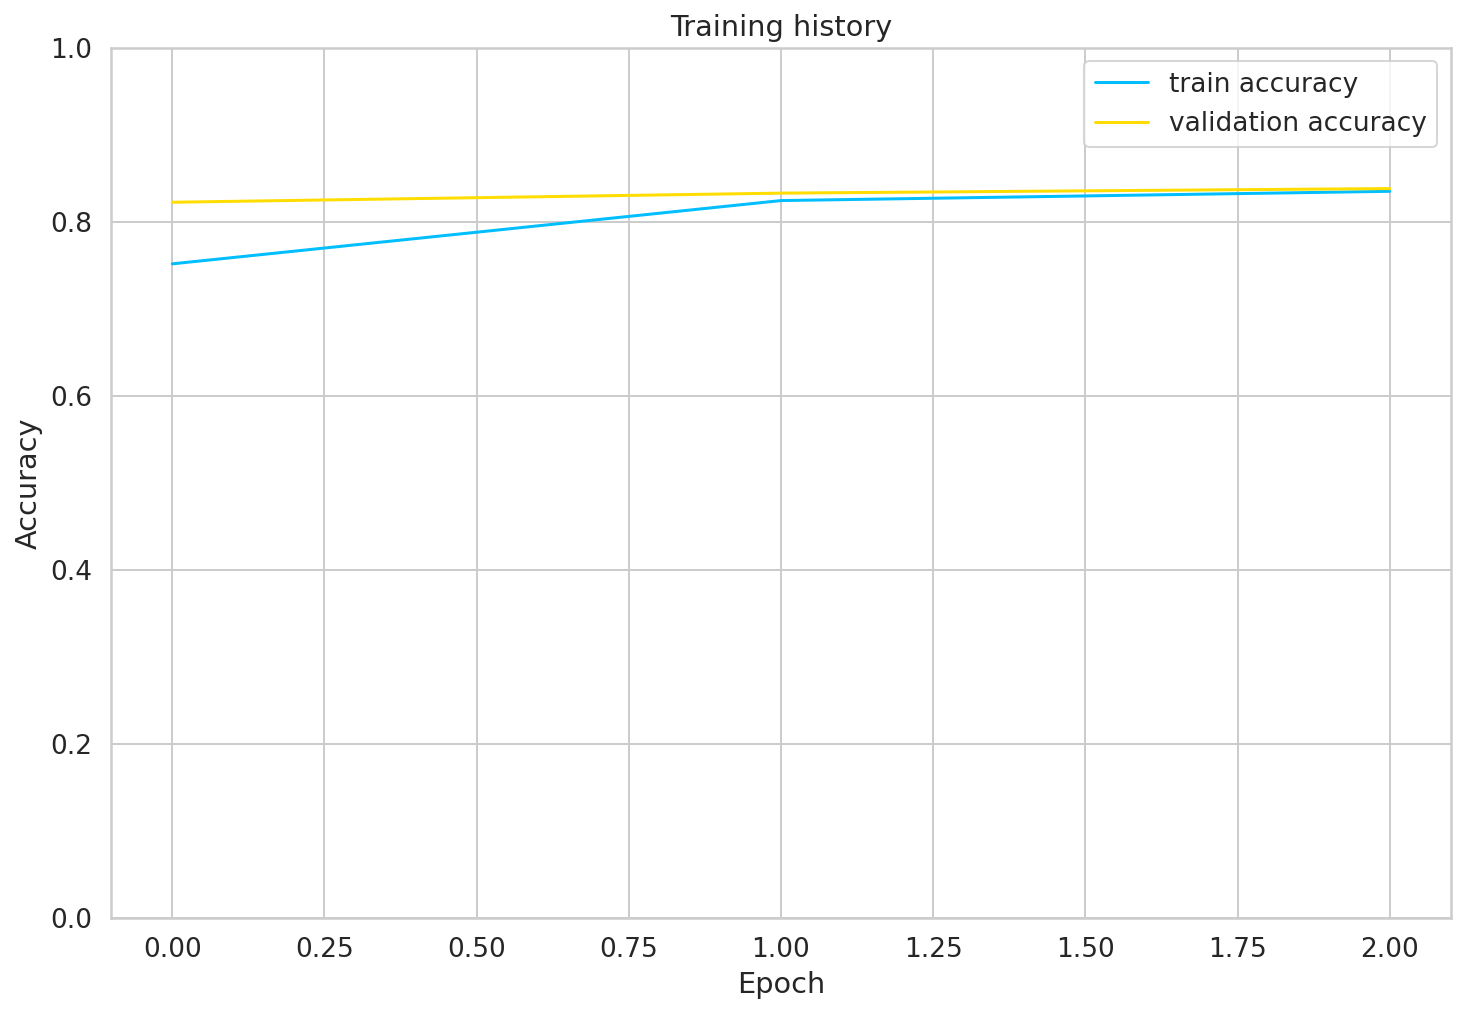

In [19]:
# Plot accuracy

def tensorToFloat(tensor):
  return tensor.item()

hist_tr_list = list(map(tensorToFloat, history['train_acc']))
hist_val_list = list(map(tensorToFloat, history['val_acc']))

hist_tr = np.array(hist_tr_list)
hist_val = np.array(hist_val_list)

plt.plot(hist_tr, label='train accuracy')
plt.plot(hist_val, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [20]:
# Evaluation 

test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.8398203592814372

In [21]:
# Prediction function

def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["headline_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [22]:
# By applying softmax on the output do prediction


y_headline_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=class_names))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


               precision    recall  f1-score   support

    sarcastic       0.87      0.84      0.86       768
not sarcastic       0.80      0.84      0.82       568

     accuracy                           0.84      1336
    macro avg       0.84      0.84      0.84      1336
 weighted avg       0.84      0.84      0.84      1336



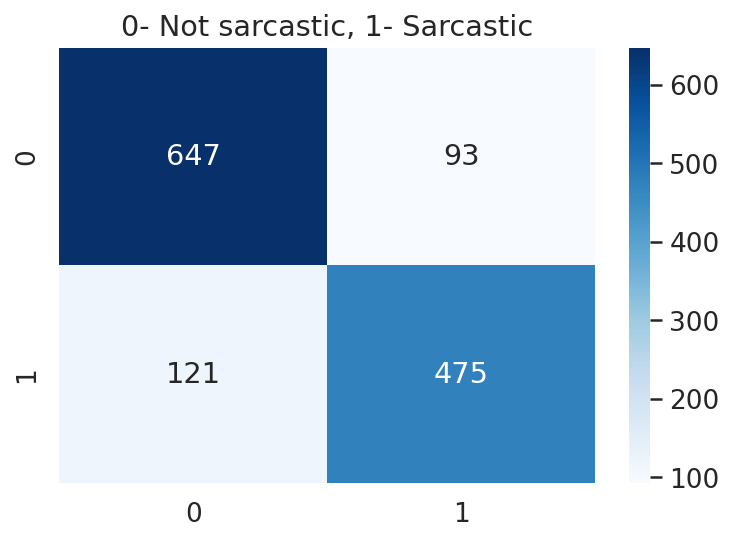

In [23]:
cm=confusion_matrix(y_pred, y_test)

plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.title("0- Not sarcastic, 1- Sarcastic")
plt.show()

Isolate missed sarcastic and non-sarcastic headlines in csv files

In [34]:
# get missed predictions indices for sarcastic/non sarcastic

missed_sarcastic, missed_non_sarcastic = [], []
def fill_missed_predictions(pred_val, test_val):
 if not is_equal(pred_val, test_val):
    if test_val == 1:
      missed_sarcastic.append(idx)
    else:
      missed_non_sarcastic.append(idx)

def is_equal(val1, val2):
  return val1 == val2

for idx, (pred_val, test_val) in enumerate(zip(y_pred, y_test)):
  fill_missed_predictions(int(pred_val), int(test_val))



0                                                                                                    jesus christ believed in
1                                                                                   youtube reaches  trillion racist comments
2     trump hails gorsuch as fierce protector of future amendment allowing president to temporarily suspend right to assemble
3                                          pretty obvious which sibling going to have to deal with all the nursing home stuff
4                                                                                             leno to tell outrageous oj joke
                                                               ...                                                           
88                                                              andme forensic kit informs customer what crimes hes committed
89                                               but a fox wouldnt eat gingerbread that one precocious little asshole 

In [54]:
def create_headline_dataframe(data):
  headline = []
  for i in data:
    value = df_test['headline'].iat[i]
    headline.append(value)
  return pd.DataFrame(headline, columns=['headline'])

missed_sarcastic_df = create_headline_dataframe(missed_sarcastic)
missed_non_sarcastic_df = create_headline_dataframe(missed_non_sarcastic)

In [55]:
# write in csv and download it
from wordcloud import WordCloud, STOPWORDS
from google.colab import files


missed_sarcastic_csv_name = 'missed_sarcastic.csv'
missed_non_sarcastic_csv_name = 'missed_non_sarcastic.csv'

df.to_csv(missed_sarcastic_csv_name, encoding = 'utf-8-sig')
df.to_csv(missed_non_sarcastic_csv_name, encoding = 'utf-8-sig') 
files.download(missed_sarcastic_csv_name)
files.download(missed_non_sarcastic_csv_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
# helper function to visualize most common words for sarcastic/non sarcastic 

from collections import Counter #import Counter for finding most common words
import seaborn as sns #import searbon for vizualization result

def visualize_common_words(text, name):
  words = text.str.split(expand=True).unstack()
  result_count = Counter(words).most_common()
  result_df = pd.DataFrame(result_count).reset_index().drop(0)

  #vizualize result
  sns.set_theme(style="whitegrid") 
  f, ax = plt.subplots(figsize=(15, 15)) 
  sns.barplot(y=result_df[0][0:30], x=result_df[1][0:30], data=result_df, palette=None)
  plt.ylabel('Words', color="blue")  # Add an x-label to the axes.
  plt.xlabel('Count', color="blue")  # Add a y-label to the axes.
  plt.title("Frequency of words in {} Headlines".format(name), color="blue") 
  plt.xticks(rotation=50);
  ax.tick_params(axis='x', colors='black')
  plt.show()

In [58]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')

def remove_stop_words(headline):
  headline = headline.apply(lambda x: [item for item in x.split() if item not in stopwords])
  headline = headline.apply(lambda x: ' '.join(map(str, x)))
  return headline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


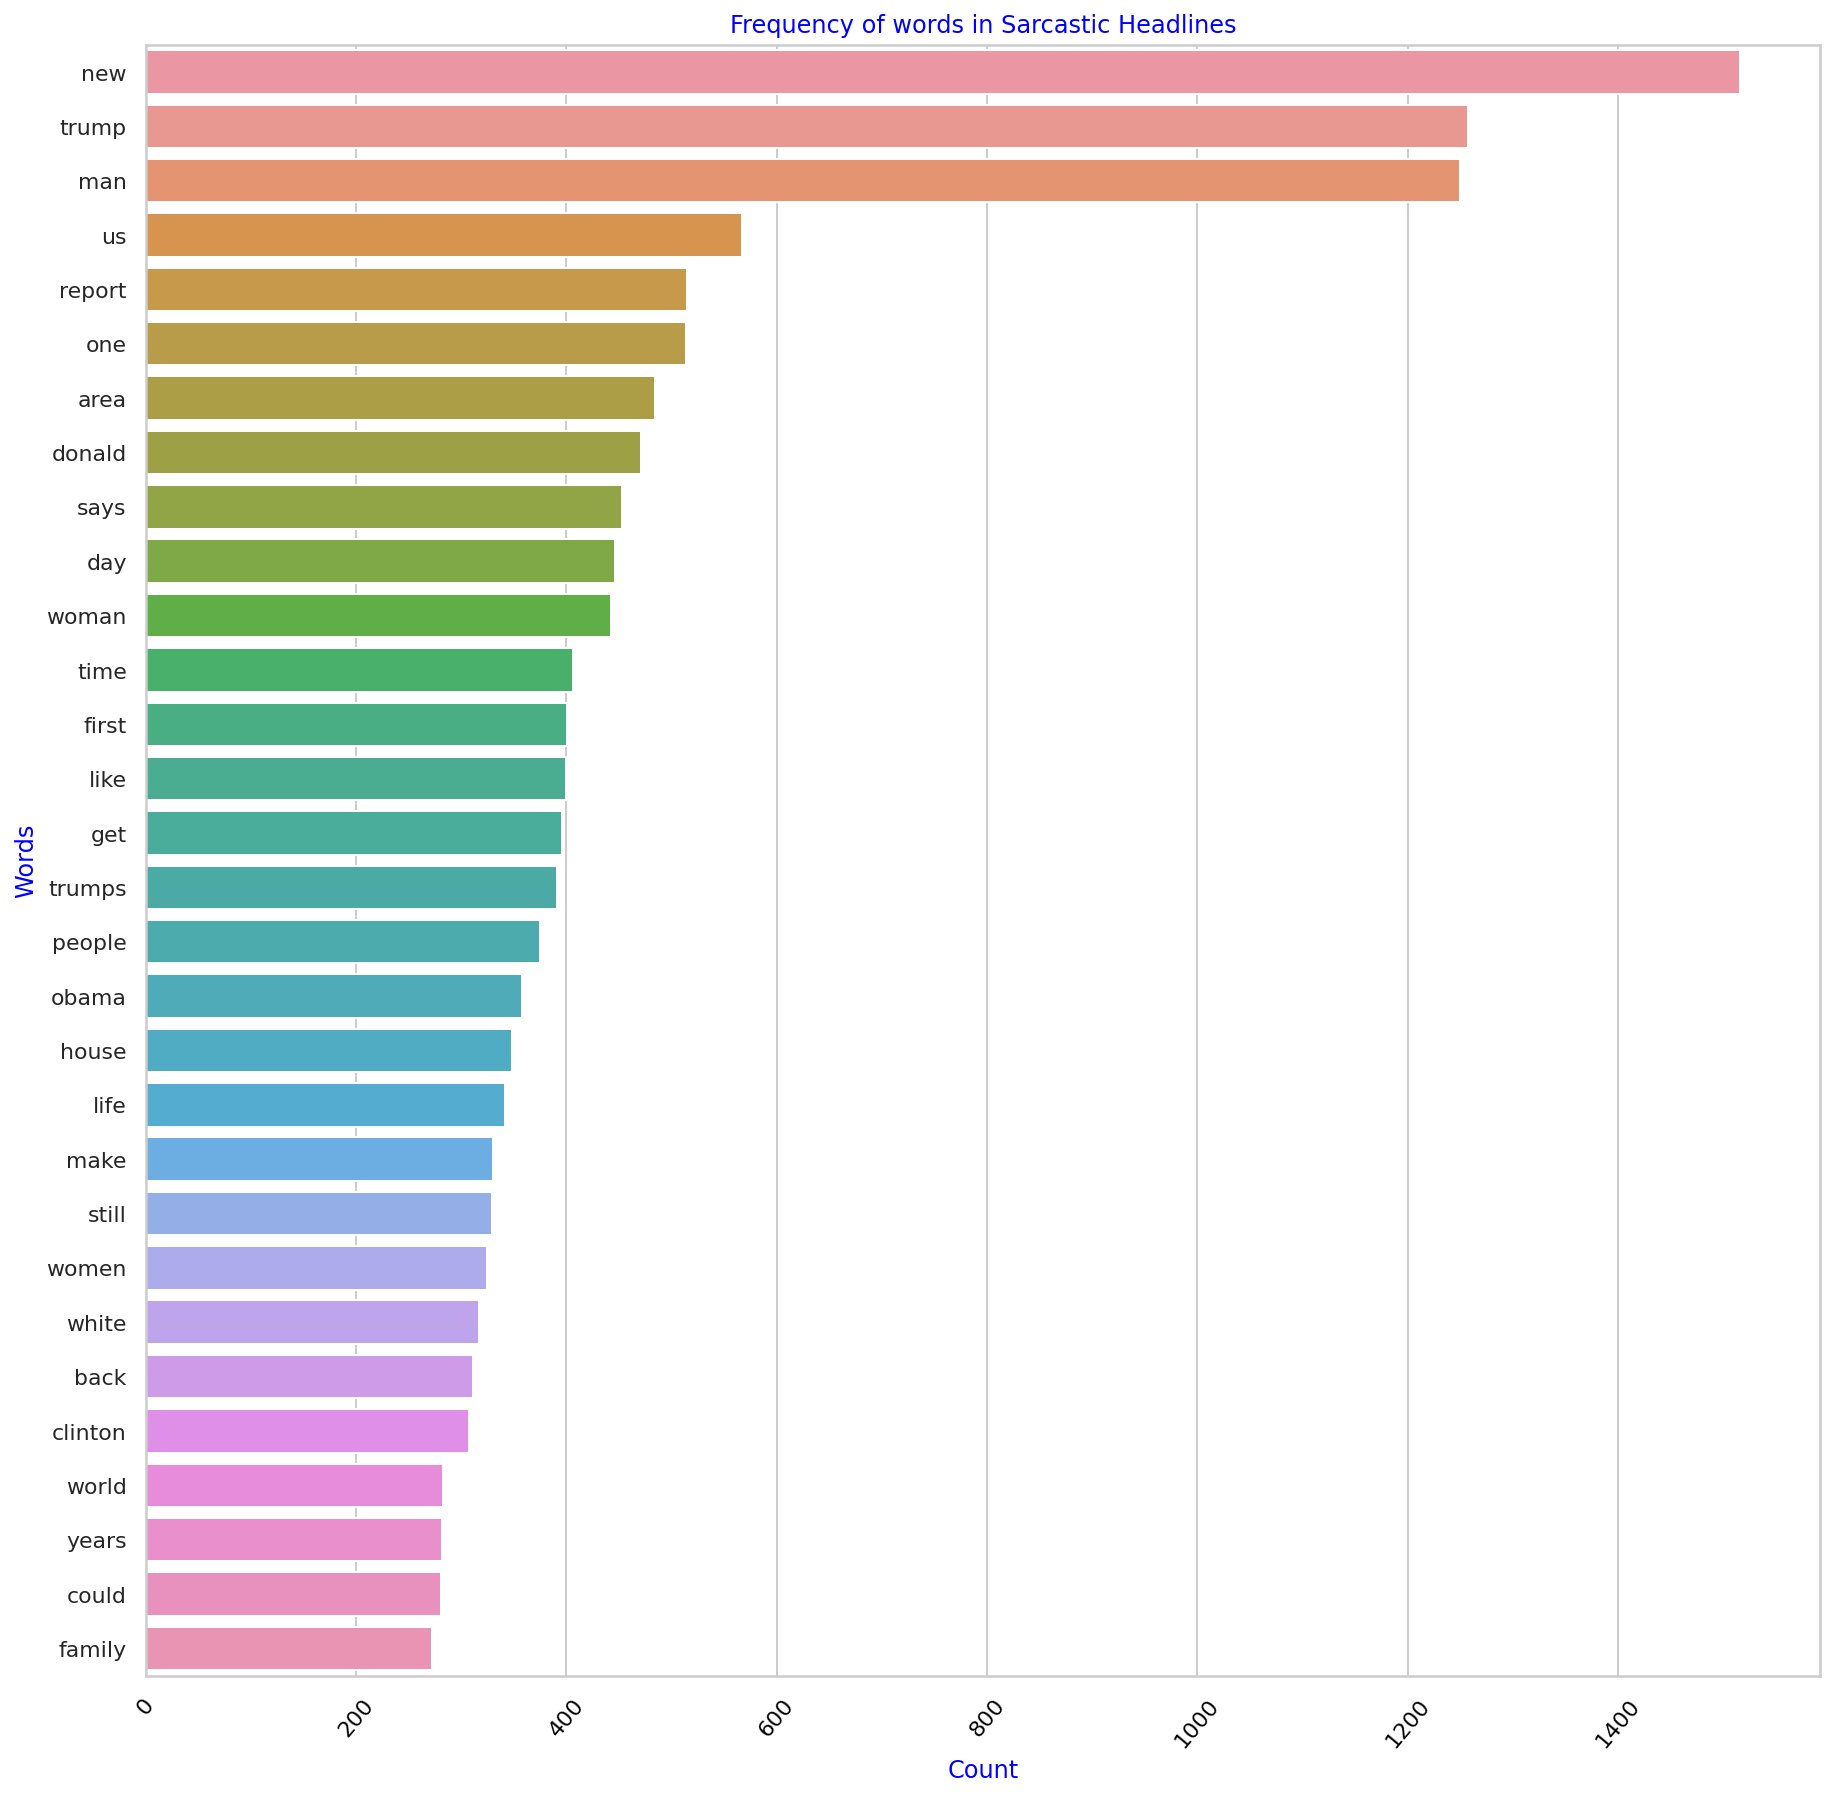

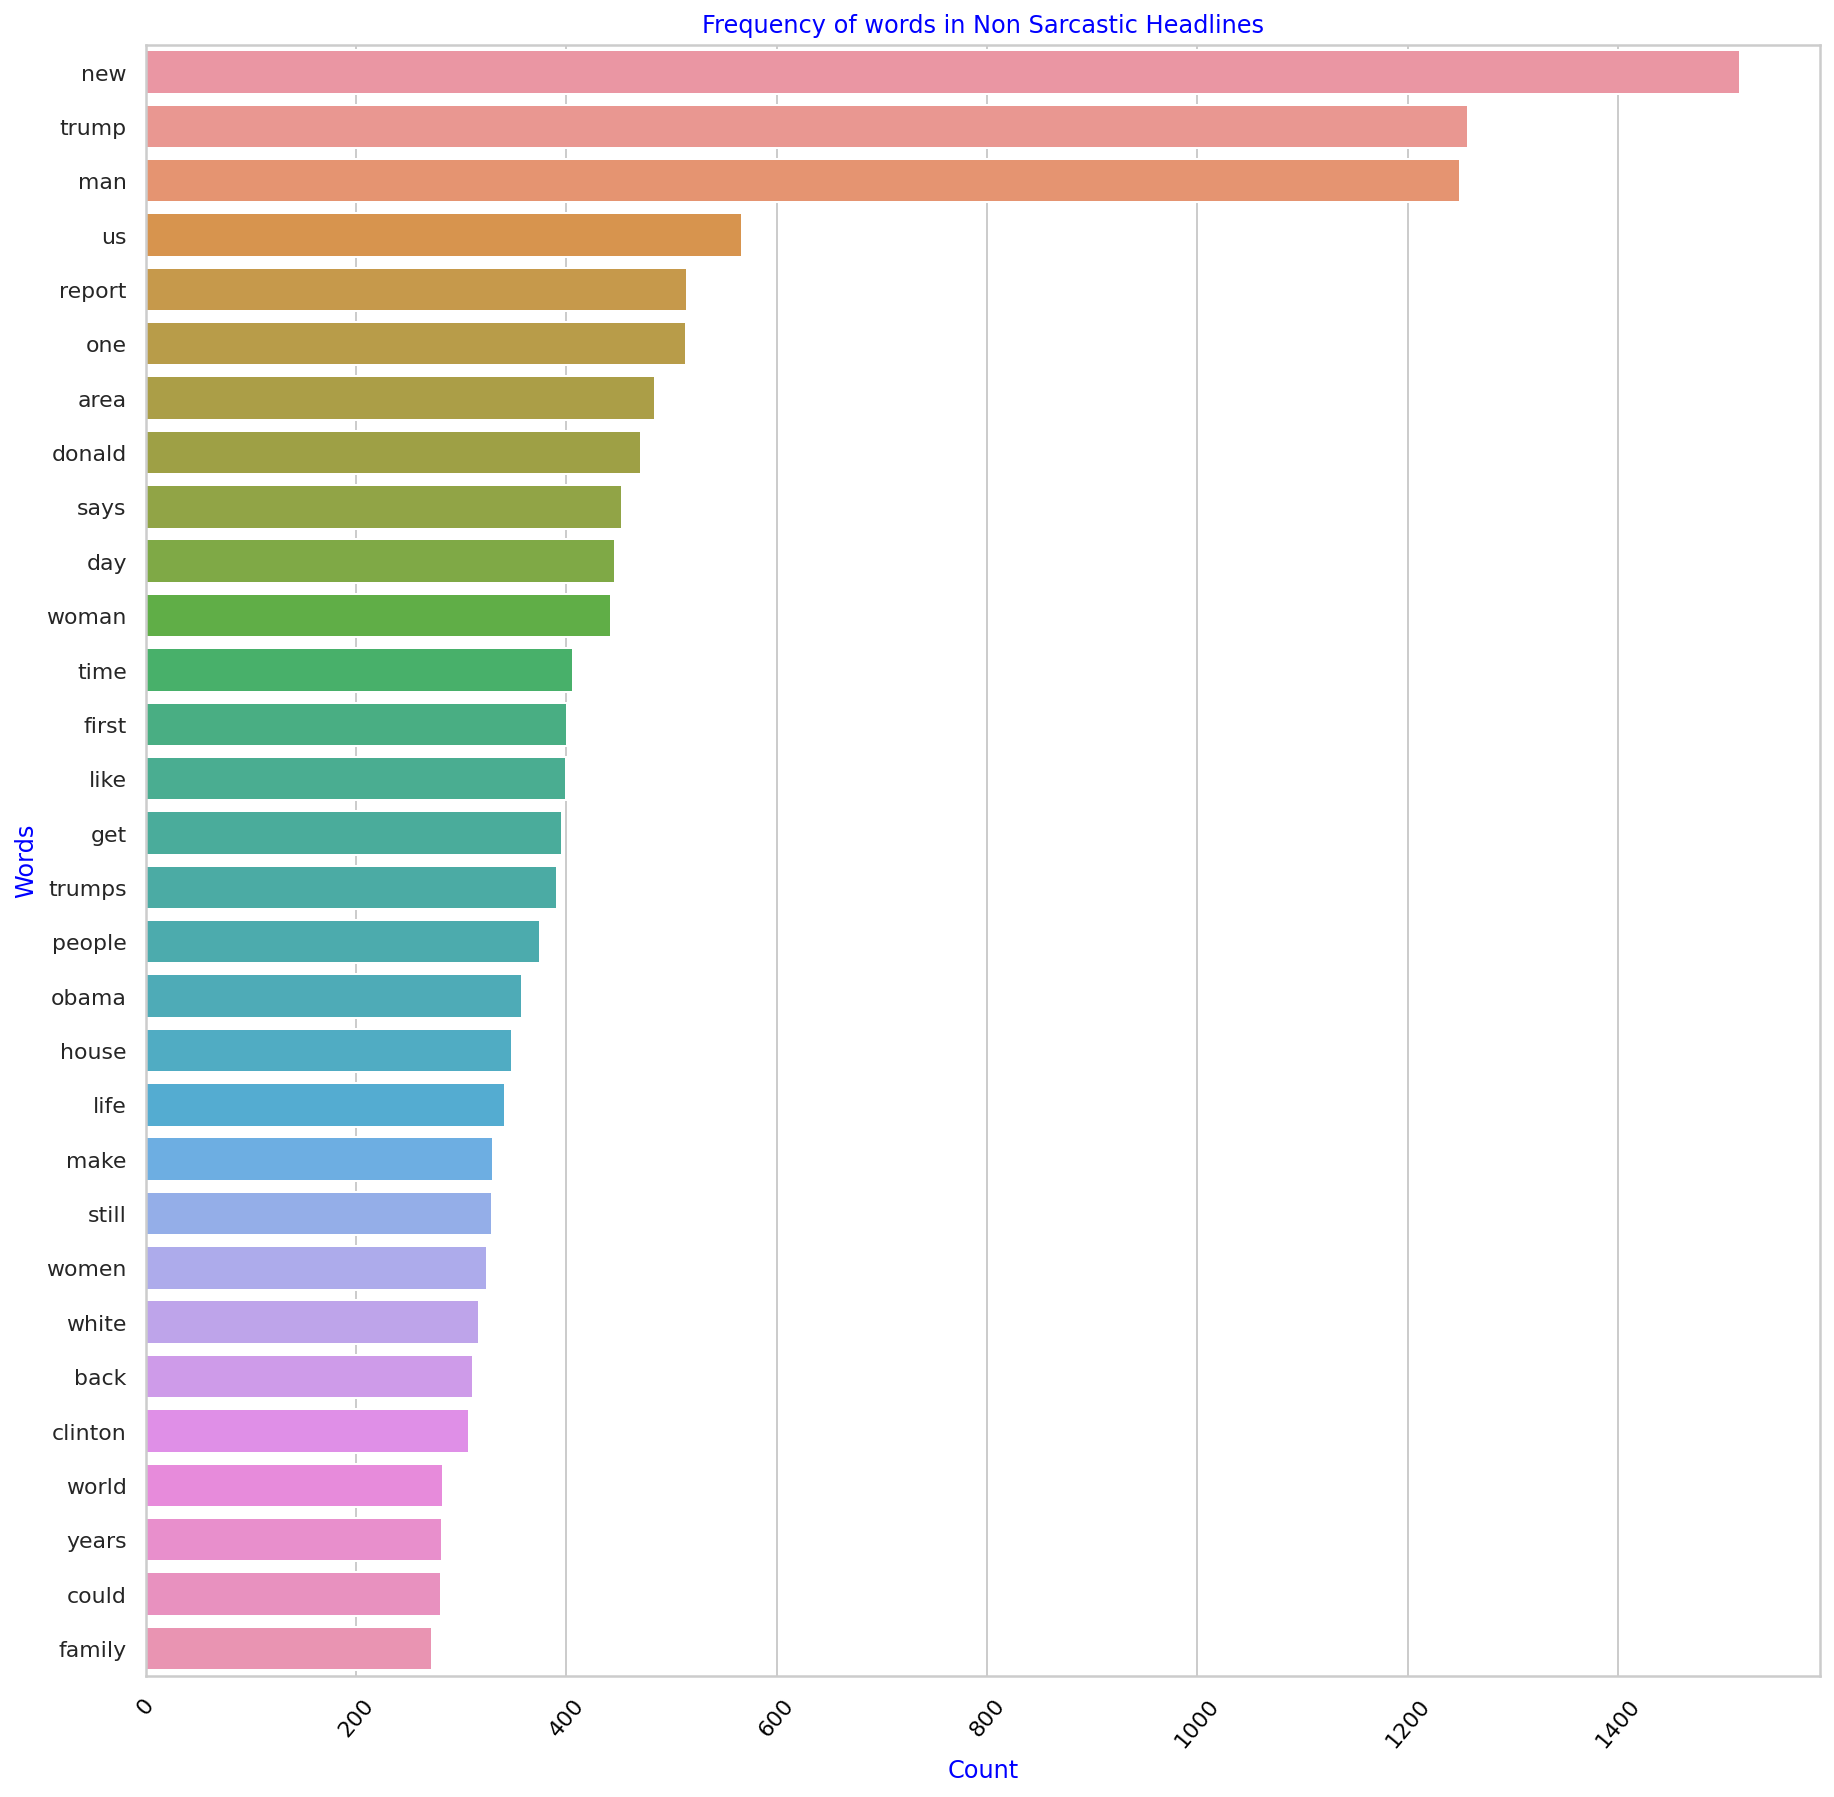

In [59]:
# common words visualization 

missed_sarcastic_df = pd.read_csv(missed_sarcastic_csv_name)
missed_non_sarcastic_df = pd.read_csv(missed_non_sarcastic_csv_name)

visualize_common_words(remove_stop_words(missed_sarcastic_df['headline']), 'Sarcastic')
visualize_common_words(remove_stop_words(missed_non_sarcastic_df['headline']), 'Non Sarcastic')

In [61]:
# visualize WordCloud function

def visualizeWordCloud(data, name):
  plt.figure(figsize=(15,10))
  wordcloud = WordCloud(width=1000, height=500,
                        max_words=300, min_font_size = 10,
                        background_color="black",
                        stopwords = stopwords, 
                        ).generate(' ' .join(word for word in data))

  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title('Wordcloud of {} Words'.format(name), color="black")
  plt.axis("off")
  plt.show()

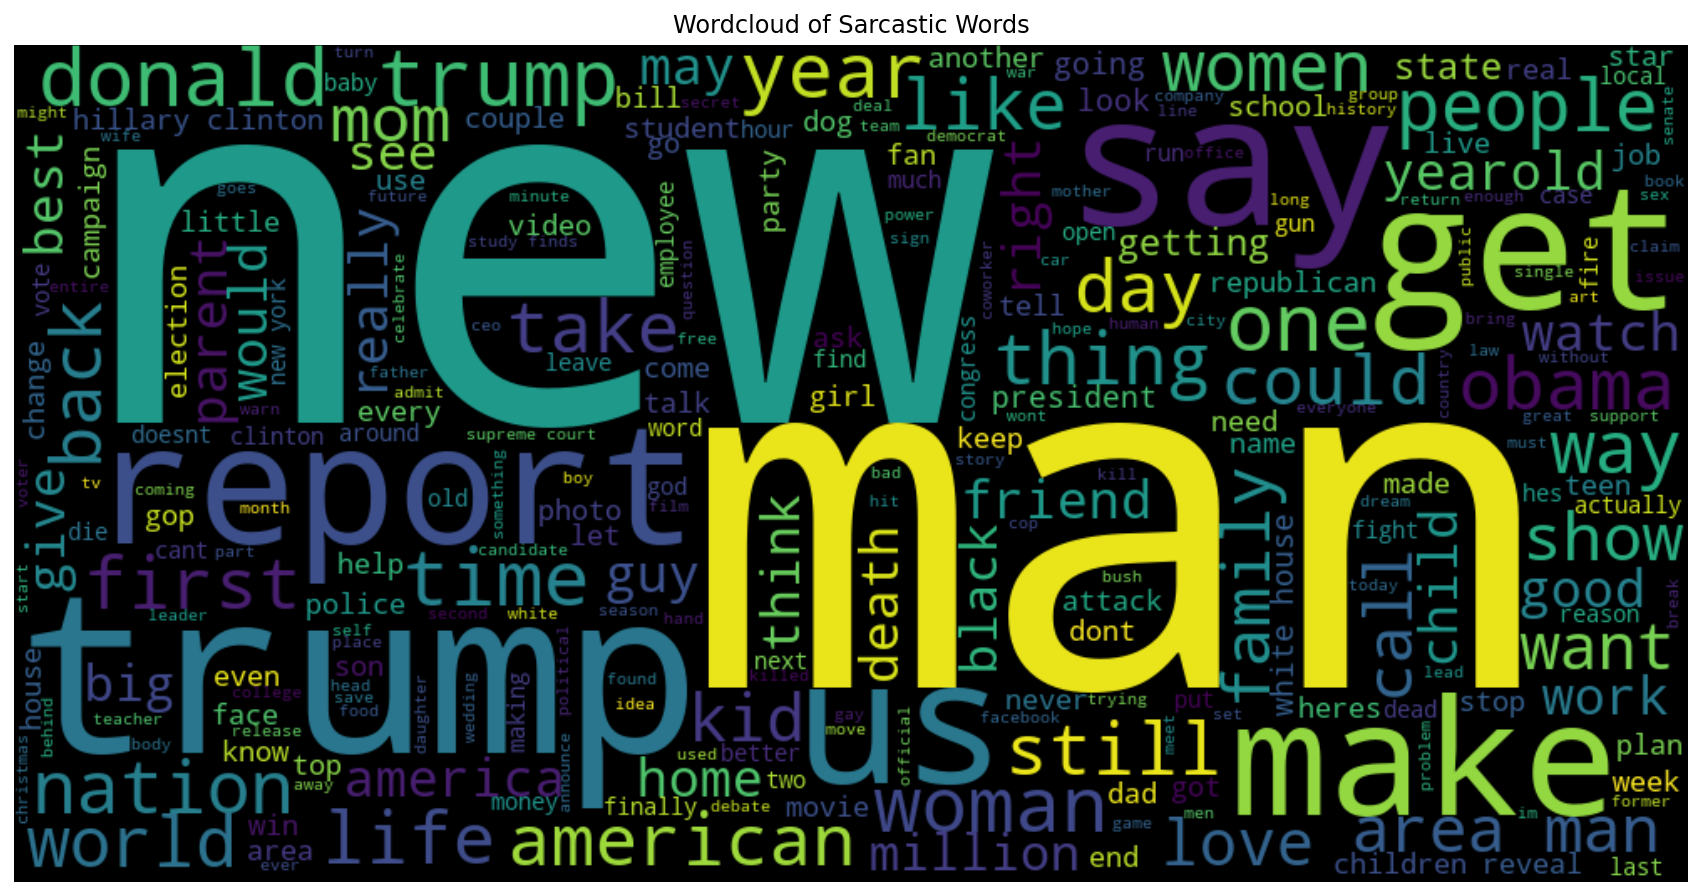

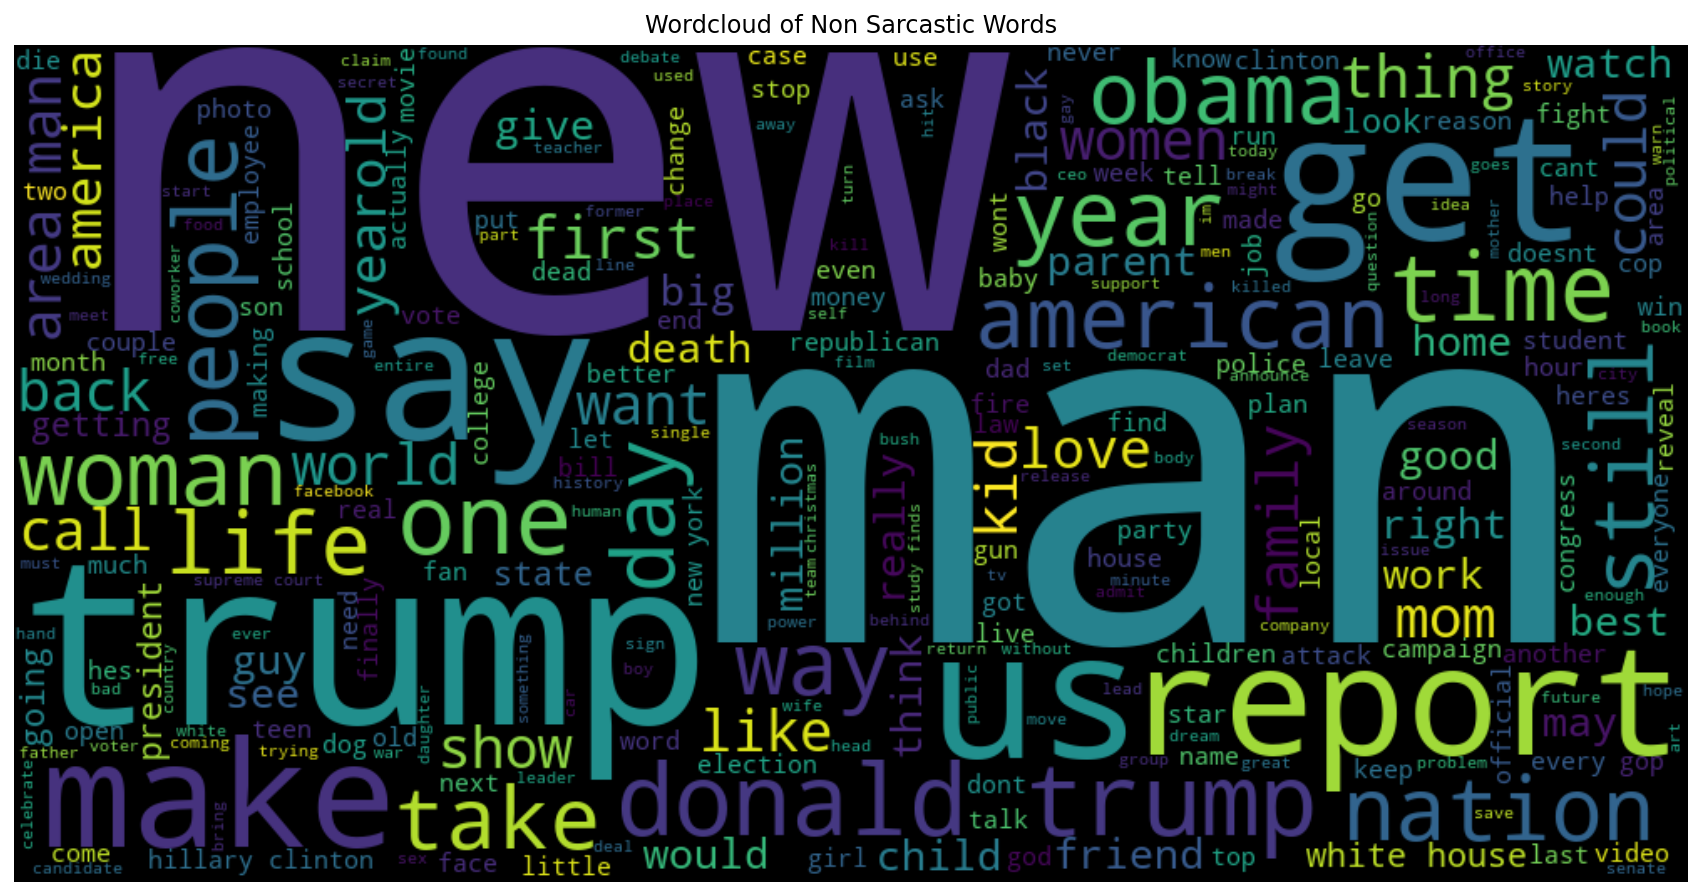

In [62]:
visualizeWordCloud(missed_sarcastic_df['headline'], 'Sarcastic')
visualizeWordCloud(missed_non_sarcastic_df['headline'], 'Non Sarcastic')